Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

train_path = "train.csv"
test_path = "test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

Excel data file

In [2]:
print(train_df)
print(test_df.head())

      MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0            120       RL         34.0     5381   Pave      IR1         Lvl   
1             20       RL         57.0     9764   Pave      IR1         Lvl   
2             60       RL        130.0    40094   Pave      IR1         Bnk   
3             20       RL          NaN     8125   Pave      Reg         Lvl   
4             60       RL          NaN    10832   Pave      IR1         Lvl   
...          ...      ...          ...      ...    ...      ...         ...   
996           20       RL         85.0    14536   Pave      Reg         Lvl   
997           70       RL         54.0     7588   Pave      Reg         Lvl   
998           20       RL         66.0     7800   Pave      IR1         Lvl   
999           20       RL         71.0     8197   Pave      Reg         Lvl   
1000          60       RL        104.0    21535   Pave      IR1         Lvl   

     Utilities LotConfig LandSlope  ... 3SsnPorch S

Delete dupplicates and fill empty cells

In [3]:
train_df.drop_duplicates(inplace= True)
test_df.drop_duplicates(inplace= True)

for column in train_df:
  if(train_df[column].dtypes == np.int64 or train_df[column].dtypes == np.float64):
    train_df[column] = train_df[column].fillna(train_df[column].median())
  else:
    train_df[column] = train_df[column].fillna("None")

for column in test_df:
  if(test_df[column].dtypes == np.int64 or test_df[column].dtypes == np.float64):
    test_df[column] = test_df[column].fillna(test_df[column].median())
  else:
    test_df[column] = test_df[column].fillna("None")

In [4]:
train_df_edit = train_df.iloc[:,:74]
saleprice_df_edit = train_df.iloc[:,74:]
test_df_edit = test_df.iloc[:,:74]
combined_df = train_df_edit.append(test_df_edit)
combined_df = pd.get_dummies(combined_df, drop_first= True)

In [5]:
new_train_df = combined_df[0:1000]
new_test_df = combined_df[1000:1459]

In [6]:
object= StandardScaler()
scaling_factor = object.fit(new_train_df)
new_train_df_norm = scaling_factor.transform(new_train_df)
new_test_df_norm = scaling_factor.transform(new_test_df)
# pd.DataFrame(new_train_df_norm, columns=new_train_df.columns).plot.box(figsize=(20,5), rot=90)
# new_test_df_norm_df = pd.DataFrame(new_train_df_norm, columns= new_train_df.columns)
# new_test_df_norm_df.to_excel('pa1test.xlsx')

Q2 Visualize the correlation between every two of the first 10 features with a 10*10 heatmap.

<AxesSubplot:>

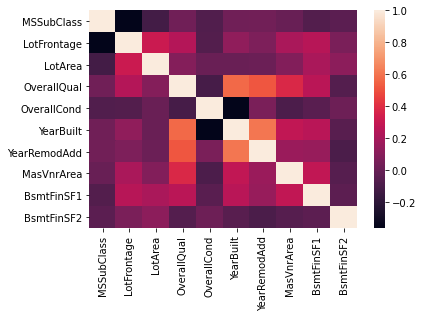

In [7]:
import seaborn as sns

q2_array = new_train_df_norm[:,:10]
q2_df = pd.DataFrame(q2_array, columns= new_train_df.columns[:10])

corr_matrix = q2_df.corr()
sns.heatmap(corr_matrix)

Q3 Use two different regression models to perform
feature selection and calculate the corresponding R^2
score.

In [8]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score

lr_train_df = pd.DataFrame(new_train_df_norm, columns= new_train_df.columns)
lr_test_df = pd.DataFrame(new_test_df_norm, columns= new_test_df.columns)
sales_train_df = saleprice_df_edit['SalePrice']
log_sales_train_df = np.log(saleprice_df_edit['SalePrice'])

selector = SelectFromModel(estimator=LinearRegression()).fit(lr_train_df, log_sales_train_df)
selected_lr_train_df = selector.transform(lr_train_df)
selected_lr_test_df = selector.transform(lr_test_df)

lr_model = LinearRegression() 
lr_model.fit(selected_lr_train_df, sales_train_df)
pred_sales_test = lr_model.predict(selected_lr_test_df)
print("R^2 Score for Linear Regression: ",r2_score(test_df['SalePrice'], pred_sales_test))

selector2 = SelectFromModel(estimator=linear_model.Lasso(alpha=0.005, random_state= 4211)).fit(lr_train_df, log_sales_train_df)
selected_lr_train_df = selector2.transform(lr_train_df)
selected_lr_test_df = selector2.transform(lr_test_df)

lasso_model = linear_model.Lasso(alpha=0.005, random_state= 4211)
lasso_model.fit(selected_lr_train_df, sales_train_df)
pred_sales_test = lasso_model.predict(selected_lr_test_df)
print("R^2 Score for Lasso Regression: ",r2_score(test_df['SalePrice'], pred_sales_test))

R^2 Score for Linear Regression:  -1.4657919531646333e+25
R^2 Score for Lasso Regression:  0.885732504811358


C:\Users\Richie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39897431479.35254, tolerance: 629598407.5635369
  model = cd_fast.enet_coordinate_descent(


Q4 

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(lr_train_df, sales_train_df, test_size=0.2, random_state=4211)
lot_area = np.reshape(X_train['LotArea'].to_numpy(),(X_train.shape[0],1))
gr_liv_area = np.reshape(X_train["GrLivArea"].to_numpy(),(X_train.shape[0],1))
overall_qual = np.reshape(X_train["OverallQual"].to_numpy(),(X_train.shape[0],1))
overall_cond = np.reshape(X_train["OverallCond"].to_numpy(),(X_train.shape[0],1))

lr_model1 = LinearRegression() 
lr_model1.fit(lot_area, y_train)
pred_sales_test1 = lr_model1.predict(np.reshape(X_test['LotArea'].to_numpy(),(X_test.shape[0],1)))
print("R^2 Score for Linear Regression Lot Area: ",r2_score(y_test, pred_sales_test1))

lr_model2 = LinearRegression() 
lr_model2.fit(gr_liv_area, y_train)
pred_sales_test2 = lr_model2.predict(np.reshape(X_test['GrLivArea'].to_numpy(),(X_test.shape[0],1)))
print("R^2 Score for Linear Regression Gr Liv Area: ",r2_score(y_test, pred_sales_test2))

lr_model3 = LinearRegression() 
lr_model3.fit(overall_qual, y_train)
pred_sales_test3 = lr_model3.predict(np.reshape(X_test['OverallQual'].to_numpy(),(X_test.shape[0],1)))
print("R^2 Score for Linear Regression Overall Qual: ",r2_score(y_test, pred_sales_test3))

lr_model4 = LinearRegression() 
lr_model4.fit(overall_cond, y_train)
pred_sales_test4 = lr_model4.predict(np.reshape(X_test['OverallCond'].to_numpy(),(X_test.shape[0],1)))
print("R^2 Score for Linear Regression Overall Cond: ",r2_score(y_test, pred_sales_test4))


R^2 Score for Linear Regression Lot Area:  0.02053447599941216
R^2 Score for Linear Regression Gr Liv Area:  0.3926843861046171
R^2 Score for Linear Regression Overall Qual:  0.5869504375679953
R^2 Score for Linear Regression Overall Cond:  0.017107462820201147


Q5

R^2 Score for Linear Regression in Q3:  -1.972371183546213e+25


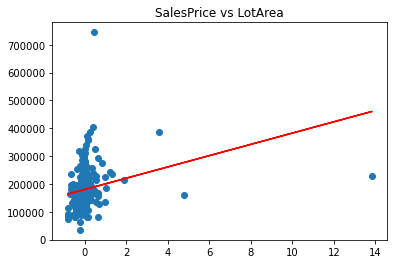

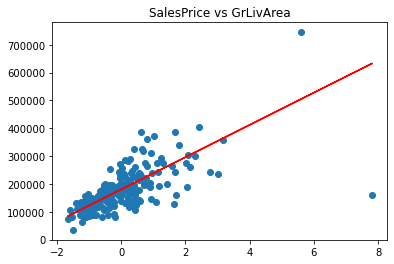

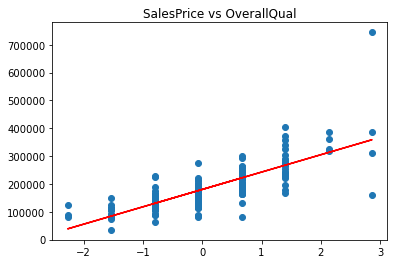

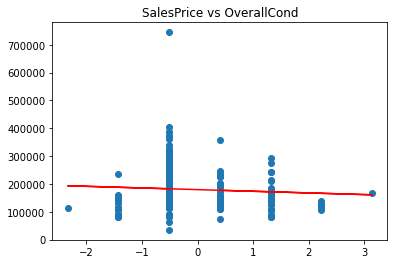

In [10]:
import matplotlib.pyplot as plt
import time

X_train2, X_test2, y_train2, y_test2 = train_test_split(selected_lr_train_df, sales_train_df, test_size=0.2, random_state=4211)
start = time.time()
lr_model5 = LinearRegression()
lr_model5.fit(X_train2, y_train2)
pred_sales_test5 = lr_model5.predict(X_test2)
stop = time.time()
print("R^2 Score for Linear Regression in Q3: ",r2_score(y_test2, pred_sales_test5))
lr_time = stop-start
lr_r2_score = r2_score(y_test2, pred_sales_test5)

plt.title("SalesPrice vs LotArea")
plt.scatter(X_test['LotArea'], y_test)
plt.plot(X_test['LotArea'], pred_sales_test1, color='red')
plt.show()

plt.title("SalesPrice vs GrLivArea")
plt.scatter(X_test['GrLivArea'], y_test)
plt.plot(X_test['GrLivArea'], pred_sales_test2, color='red')
plt.show()

plt.title("SalesPrice vs OverallQual")
plt.scatter(X_test['OverallQual'], y_test)
plt.plot(X_test['OverallQual'], pred_sales_test3, color='red')
plt.show()

plt.title("SalesPrice vs OverallCond")
plt.scatter(X_test['OverallCond'], y_test)
plt.plot(X_test['OverallCond'], pred_sales_test4, color='red')
plt.show()

Q6

In [11]:
from sklearn.neural_network import MLPRegressor
import time

hidden_layer_unit = [1,2,4,8,16,32,64,128]
random_state = [12, 102, 3006]
X_train, X_test, y_train, y_test = train_test_split(selected_lr_train_df, sales_train_df, test_size=0.2, random_state=4211)

for i in hidden_layer_unit:
    total_time = []
    total_score = []
    for j in random_state:
        start = time.time()
        regr = MLPRegressor(hidden_layer_sizes=(i,i,i,i,i,i), max_iter= 500, early_stopping= True, random_state= j).fit(X_train, y_train)
        feed_predict = regr.predict(X_test)
        stop = time.time()
        r_score = r2_score(y_test, feed_predict)
        print("R^2 Score for Feed Forward Network (H =", i,"random_state=", j,"): ",r_score)
        print("Training time: ",stop-start,"s")
        total_time.append(stop-start)
        total_score.append(r_score)
    print("Mean Training Time: ",np.mean(total_time))
    print("STD Training Time: ",np.std(total_time))
    print("Mean R^2 Score: ",np.mean(total_score))
    print("STD R^2 Score: ",np.std(total_score))
    print("")

R^2 Score for Feed Forward Network (H = 1 random_state= 12 ):  -5.2266038743207
Training time:  0.04612088203430176 s
R^2 Score for Feed Forward Network (H = 1 random_state= 102 ):  -5.226595903059875
Training time:  0.046022653579711914 s
R^2 Score for Feed Forward Network (H = 1 random_state= 3006 ):  -5.226473283347459
Training time:  0.044020652770996094 s
Mean Training Time:  0.04538806279500326
STD Training Time:  0.0009677361340225019
Mean R^2 Score:  -5.226557686909345
STD R^2 Score:  5.9770986239538704e-05

R^2 Score for Feed Forward Network (H = 2 random_state= 12 ):  -5.2265352964441725
Training time:  0.06801366806030273 s
R^2 Score for Feed Forward Network (H = 2 random_state= 102 ):  -5.226459418432854
Training time:  0.0620119571685791 s
R^2 Score for Feed Forward Network (H = 2 random_state= 3006 ):  -5.226507976633178
Training time:  0.06501460075378418 s
Mean Training Time:  0.06501340866088867
STD Training Time:  0.0024501883564020982
Mean R^2 Score:  -5.226500897170

Q7

In [12]:
print("Linear Regression Time: ",lr_time)
print("Linear Regression in R^2 Score: ",lr_r2_score)
print("")
print("R^2 Score for Feed Forward Network (H = 128 ): 0.7078087803122424")
print("Mean Training Time:  0.6908837954203287")

Linear Regression Time:  0.004001140594482422
Linear Regression in R^2 Score:  -1.972371183546213e+25

R^2 Score for Feed Forward Network (H = 128 ): 0.7078087803122424
Mean Training Time:  0.6908837954203287


Q8 in report

Q9

In [13]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

random_state = [600, 850, 1500]
total_time=[]
total_f1=[]
total_acc=[]
label_train_df = saleprice_df_edit['label']
X_train, X_test, y_train, y_test = train_test_split(selected_lr_train_df, label_train_df, test_size=0.2, random_state=4211)

for i in random_state:
    start = time.time()
    clf_model = make_pipeline(StandardScaler(), SGDClassifier(loss="log", random_state= i, learning_rate="constant", eta0= 0.5))
    clf_model.fit(X_train, y_train)
    predict_clf_label = clf_model.predict(X_test)
    stop = time.time()
    total_time.append(stop-start)
    total_f1.append(f1_score(y_test, predict_clf_label))
    total_acc.append(accuracy_score(y_test, predict_clf_label))
    
    print("Random State: ", i)
    print("F1 Score: ",f1_score(y_test, predict_clf_label))
    print("Accuracy: ",accuracy_score(y_test, predict_clf_label))
    print("Training time: ",stop-start,"s")
    print("")

print("Mean of F1 Score: ", np.mean(total_f1))
print("STD of F1 Score: ", np.std(total_f1))
print("Mean of Accuracy: ", np.mean(total_acc))
print("STD of Accuracy: ", np.std(total_acc))
print("Mean of Training time: ", np.mean(total_time))
print("STD of Training time: ", np.std(total_time))

Random State:  600
F1 Score:  0.9101796407185629
Accuracy:  0.925
Training time:  0.009001970291137695 s

Random State:  850
F1 Score:  0.8846153846153847
Accuracy:  0.91
Training time:  0.005001068115234375 s

Random State:  1500
F1 Score:  0.8917197452229298
Accuracy:  0.915
Training time:  0.007001638412475586 s

Mean of F1 Score:  0.895504923518959
STD of F1 Score:  0.0107743051926569
Mean of Accuracy:  0.9166666666666666
STD of Accuracy:  0.006236095644623242
Mean of Training time:  0.007001558939615886
STD of Training time:  0.0016333614745923882


Q10

True Negative: 113, False Positive: 7, False Negative: 10, True Positive: 70


<AxesSubplot:>

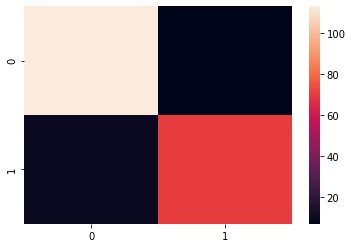

In [14]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, predict_clf_label).ravel()
conf_matrix = confusion_matrix(y_test, predict_clf_label)
print(f"True Negative: {tn}, False Positive: {fp}, False Negative: {fn}, True Positive: {tp}")
sns.heatmap(conf_matrix)

Q11

In [15]:
from sklearn.neural_network import MLPClassifier

random_state = [600, 850, 1500]
mean_score=[]
mean_accuracy=[]
for i in hidden_layer_unit:
    total_time=[]
    total_score=[]
    total_acc=[]
    for j in random_state:
        start = time.time()
        clfnn_model = MLPClassifier(hidden_layer_sizes=(i,i,i), max_iter= 500, early_stopping= True, random_state= j).fit(X_train, y_train)
        nn_predict = clfnn_model.predict(X_test)
        stop = time.time()
        total_time.append(stop-start)
        total_score.append(f1_score(y_test, nn_predict))
        total_acc.append(accuracy_score(y_test, nn_predict))
        print("F1 Score      for H= ",i,"Random =,",j," : ", f1_score(y_test, nn_predict))
        print("Accuracy      for H= ",i,"Random =,",j," : ", accuracy_score(y_test, nn_predict))
        print("Training time for H= ",i,"Random =,",j," : ", stop-start,"s")
    mean_score.append(np.mean(total_score))
    mean_accuracy.append(np.mean(total_acc))
    print("")
    print("Mean of F1 Score      for H= ",i," : ",np.mean(total_score))
    print("STD  of F1 Score      for H= ",i," : ",np.std(total_score))
    print("Mean of Accuracy      for H= ",i," : ",np.mean(total_acc))
    print("STD  of Accuracy      for H= ",i," : ",np.std(total_acc))
    print("Mean of Training time for H= ",i," : ",np.mean(total_time))
    print("STD  of Training time for H= ",i," : ",np.std(total_time))
    print("")

F1 Score      for H=  1 Random =, 600  :  0.0
Accuracy      for H=  1 Random =, 600  :  0.6
Training time for H=  1 Random =, 600  :  0.02800917625427246 s
F1 Score      for H=  1 Random =, 850  :  0.0
Accuracy      for H=  1 Random =, 850  :  0.6
Training time for H=  1 Random =, 850  :  0.027015209197998047 s
F1 Score      for H=  1 Random =, 1500  :  0.0
Accuracy      for H=  1 Random =, 1500  :  0.6
Training time for H=  1 Random =, 1500  :  0.0279238224029541 s

Mean of F1 Score      for H=  1  :  0.0
STD  of F1 Score      for H=  1  :  0.0
Mean of Accuracy      for H=  1  :  0.6
STD  of Accuracy      for H=  1  :  0.0
Mean of Training time for H=  1  :  0.027649402618408203
STD  of Training time for H=  1  :  0.00044979424248009893

F1 Score      for H=  2 Random =, 600  :  0.0
Accuracy      for H=  2 Random =, 600  :  0.6
Training time for H=  2 Random =, 600  :  0.03400683403015137 s
F1 Score      for H=  2 Random =, 850  :  0.7958115183246074
Accuracy      for H=  2 Random =, 

Q12

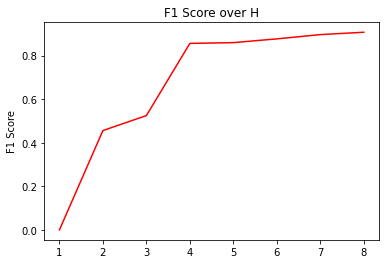

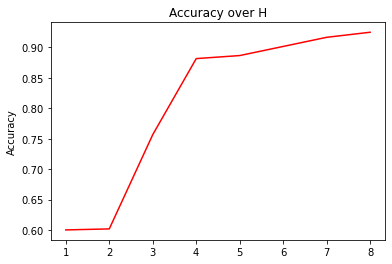

In [16]:
x = np.arange(1, 9)
plt.title("F1 Score over H")
plt.ylabel("F1 Score")
plt.plot(x, mean_score, color ="red")
plt.show()

plt.title("Accuracy over H")
plt.ylabel("Accuracy")
plt.plot(x, mean_accuracy, color ="red")
plt.show()

Q13

In [17]:
print("Best NN Model F1 Score: ", mean_score[7])
print("Best NN Model Accuracy: ", mean_accuracy[7])
print("Logistic Regression F1 Score : 0.895504923518959")
print("Logistic Regression Accuracy : 0.9166666666666666")

Best NN Model F1 Score:  0.9068121630976512
Best NN Model Accuracy:  0.9250000000000002
Logistic Regression F1 Score : 0.895504923518959
Logistic Regression Accuracy : 0.9166666666666666


Q14 in Report

Q15

In [18]:
from sklearn.model_selection import GridSearchCV

selected_train_df = selected_lr_train_df     #selected test dataset
selected_test_df = selected_lr_test_df       #selected train dataset
res_train_df = saleprice_df_edit['label']    #training saleprice and label
res_test_df = test_df['label']               #test saleprice and label

random_state=[100, 200, 300, 400, 500]
parameters={'hidden_layer_sizes':[(32,32,32),(64,64,64),(128,128,128),(256,256,256)], 'alpha':[0.0001, 0.1], 'learning_rate_init':[0.001,0.01,0.1], 'early_stopping': [True], 'random_state': [4211], 'max_iter': [500]}
X_train, X_test, y_train, y_test = train_test_split(selected_train_df, res_train_df, test_size=0.2, random_state=4211)

clf_model_tuning = MLPClassifier()
grid_tuning = GridSearchCV(clf_model_tuning, parameters, cv=5, scoring= 'accuracy')
grid_tuning.fit(X_train, y_train)

print(pd.DataFrame(grid_tuning.cv_results_))
print(grid_tuning.cv_results_['params'])

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0        0.086820      0.008799         0.000601    4.904465e-04      0.0001   
1        0.062213      0.008731         0.000401    4.906226e-04      0.0001   
2        0.063014      0.012085         0.000600    4.901350e-04      0.0001   
3        0.129229      0.013123         0.001001    9.368364e-07      0.0001   
4        0.090221      0.025955         0.000600    4.897071e-04      0.0001   
5        0.102624      0.015098         0.000600    4.895512e-04      0.0001   
6        0.181442      0.037526         0.001000    6.468134e-07      0.0001   
7        0.142032      0.029813         0.001000    5.519789e-07      0.0001   
8        0.184443      0.038369         0.001000    4.623108e-07      0.0001   
9        0.337078      0.035919         0.002000    1.326602e-06      0.0001   
10       0.305870      0.052644         0.001600    4.900573e-04      0.0001   
11       0.385288      0.107688         

Q16

In [19]:
top3_tuning_settings = np.argpartition(grid_tuning.cv_results_['rank_test_score'], 3)[:3]
tuning_results_df = pd.DataFrame(grid_tuning.cv_results_)
top3_tuning_results_params = tuning_results_df['params'].iloc[top3_tuning_settings]
for index in top3_tuning_settings:
    params = tuning_results_df['params'].iloc[index]
    nn_classifier_model = MLPClassifier(max_iter=500, early_stopping= True, hidden_layer_sizes= params['hidden_layer_sizes'], random_state= 4211, learning_rate_init= params['learning_rate_init']).fit(X_train, y_train)
    nn_classifier_predict = nn_classifier_model.predict(X_test)
    print(params)
    print("Accuracy: ", accuracy_score(y_test, nn_classifier_predict))
    print("Mean score: ", tuning_results_df['mean_test_score'].iloc[index])
    print("STD score: ", tuning_results_df['std_test_score'].iloc[index])
    print("")

{'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (128, 128, 128), 'learning_rate_init': 0.01, 'max_iter': 500, 'random_state': 4211}
Accuracy:  0.93
Mean score:  0.9337500000000001
STD score:  0.004999999999999982

{'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (128, 128, 128), 'learning_rate_init': 0.01, 'max_iter': 500, 'random_state': 4211}
Accuracy:  0.93
Mean score:  0.9325000000000001
STD score:  0.002499999999999991

{'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (64, 64, 64), 'learning_rate_init': 0.1, 'max_iter': 500, 'random_state': 4211}
Accuracy:  0.92
Mean score:  0.925
STD score:  0.007905694150420974



Q17

Accuracy:  0.9128540305010894
F1 Score:  0.8924731182795699
True Negative: 253, False Positive: 22, False Negative: 18, True Positive: 166


<AxesSubplot:>

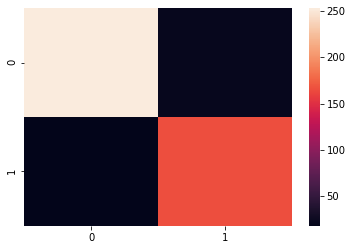

In [20]:
best_tuning_params = tuning_results_df['params'].iloc[top3_tuning_settings[0]]
best_params_model = MLPClassifier(max_iter= 500, early_stopping= True, hidden_layer_sizes= best_tuning_params['hidden_layer_sizes'], random_state= 4211, learning_rate_init= best_tuning_params['learning_rate_init']).fit(selected_train_df, res_train_df)
best_predict = best_params_model.predict(selected_test_df)
print("Accuracy: ", accuracy_score(res_test_df, best_predict))
print("F1 Score: ", f1_score(res_test_df, best_predict))

tn, fp, fn, tp = confusion_matrix(res_test_df, best_predict).ravel()
conf_matrix = confusion_matrix(res_test_df, best_predict)
print(f"True Negative: {tn}, False Positive: {fp}, False Negative: {fn}, True Positive: {tp}")
sns.heatmap(conf_matrix)